# Early Experiments in Comparing Models

This notebook explores combining feature visualization with some similar ideas to [Raghu et al's SVCCA paper](https://arxiv.org/pdf/1706.05806.pdf). 

## Setup

*Feel free to ignore this section :)*

In [0]:
!pip install --upgrade git+https://github.com/tensorflow/lucid.git

In [0]:
import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.misc.io.showing import _image_url, _display_html
import lucid.scratch.pretty_graphs.visualizations as vis
from lucid.misc.io import show, load
from lucid.recipes.caricature import feature_inversion

import lucid.misc.io.showing

In [0]:
_Cs = {}
def C(layer1, layer2=None):
  if layer2 is None:
    layer2 = layer1
  if (layer1, layer2) not in _Cs:
    act1, act2 = layer1.activations, layer2.activations
    _Cs[(layer1, layer2)] = np.matmul(act1.T, act2) / len(act1)
  return _Cs[(layer1, layer2)] 


_C_i_chols = {}
def C_i_chol(layer):
  if layer not in _C_i_chols:
    _C_i_chols[layer] = np.linalg.cholesky(np.linalg.inv(C(layer)))
  return _C_i_chols[layer]


In [0]:
InceptionV1 = models.InceptionV1()
InceptionV1.load_graphdef()

InceptionV2 = models.InceptionV2_slim()
InceptionV2.load_graphdef()

AlexNet = models.AlexNet()
AlexNet.load_graphdef()

## Comparing Models: Caricatures

Caricatures are a simple visualization that is *comparable across models*, by focusing on a single data set example. Let's display them in context by linking them to a model graph.

In [0]:
def make_caricature_tooltips(model, img, layers, n_steps=128, cossim_pow=0.0):
  """Create tooltips for layers of the form:
  
  > layer name
  > [caricature image]
  
  Returns dictionary of the form {layer_name: html fragment} for use in
  visualizations as a collection of tooltip.
  """
  
  result = feature_inversion(img, model, layers, n_steps=n_steps,
                             cossim_pow=cossim_pow, verbose=False)

  tooltips = {}
  for layer, caricature in zip (layers, result[1:]):
    data_url = _image_url(caricature)
    tooltips[layer] = "<div>%s</div><img src=\"%s\"></img>" % (layer, data_url)
  return tooltips

In [0]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

In [0]:
layers = [layer.name for layer in InceptionV1.layers if 'conv' in layer.tags and (layer.name.startswith('conv') or layer.name.startswith('mixed'))]
tooltips = make_caricature_tooltips(InceptionV1, img, layers)


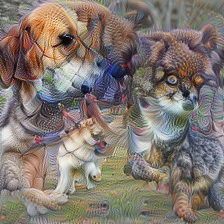
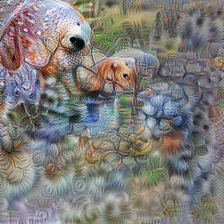
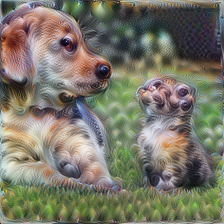
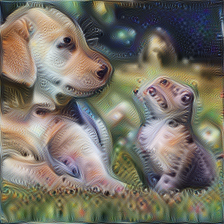
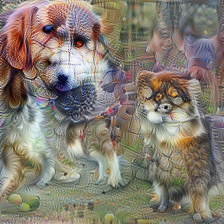
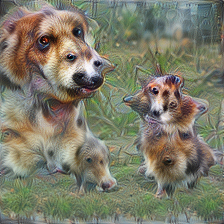
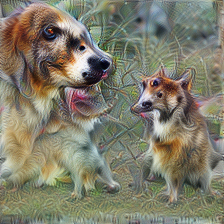
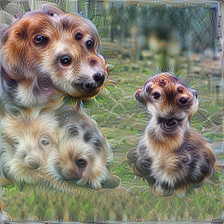
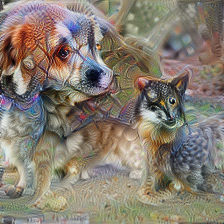
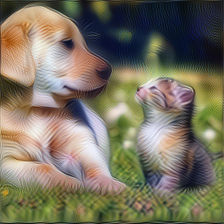
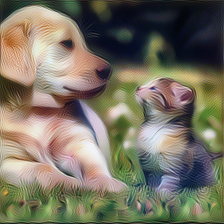
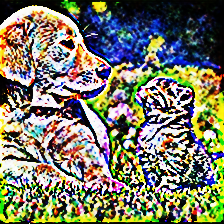


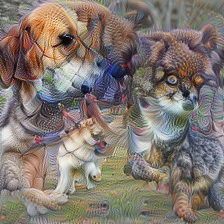
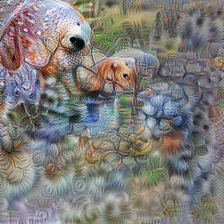
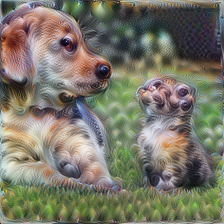
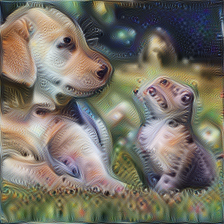
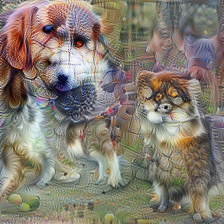
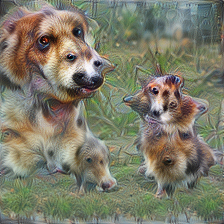
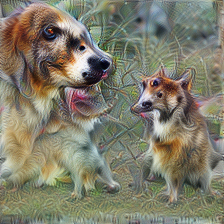
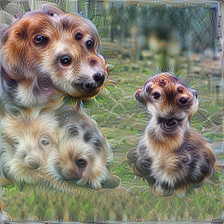
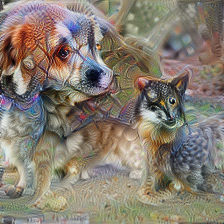
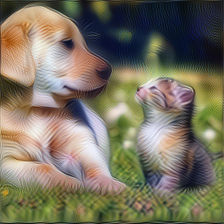
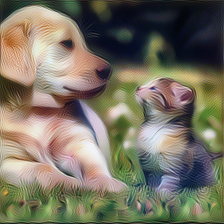
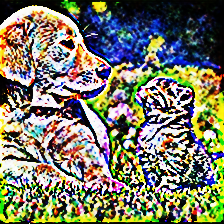

In [13]:
vis.vpad(40)
vis.display_model(InceptionV1)
vis.display_tooltips(".background", "data-group-tf-name", tooltips)
vis.display_tooltips(".node", "data-tf-name", tooltips)
vis.vpad(240)

## Comparing Models: How similar are layers?

For this section, there are two functions that we need to care about:

* **`C(x)`** or **`C(x,y)`** give use the emperical covariance between layers. *Caching and memoized.*

* **`C_i_chol(x)`** gives the cholesky decomposition of the inverse of `C(x)`. *Memoized.*

* **`model_align_display(model1, model2, lines)`** creates a visualization of the similarity between two models.


In [0]:
layers = [layer for layer in InceptionV1.layers if 'conv' in layer.tags and (layer.name.startswith('conv') or layer.name.startswith('mixed'))]

In [0]:
def naive_similarity(layer1, layer2):
  """Mean eigen value of correlation matrix betweened whitened layers."""
  whiten1 = C_i_chol(layer1)
  whiten2 = C_i_chol(layer2)
  correl = C(layer1, layer2)
  A = np.dot(np.dot(whiten1.T, correl), whiten2)
  return np.linalg.svd(A)[1].sum() / max(correl.shape)

In [16]:
def make_lines(layers1, layers2, similarity_f):
  """Create a dictionary of weighted lines.
  
  Returns a dictionarity of the form: { (source, dest): weight }
  """
  lines = {}
  for layer1 in layers1:
    for layer2 in layers2:
      print ".",
      lines[(layer1.name, layer2.name)] = similarity_f(layer1, layer2)

  lines_max = max(lines.values())
  for k in lines:
    lines[k] /= lines_max
    
  return lines

In [17]:
# example of filtering layers by tag and name
layers = [layer for layer in InceptionV1.layers if 'conv' in layer.tags and (layer.name.startswith('conv') or layer.name.startswith('mixed'))]

# compute layerwise similarities
lines = make_lines(layers, layers, naive_similarity)

vis.model_align_display(InceptionV1, InceptionV1, lines=lines)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [20]:
InceptionV1_layers = [layer for layer in InceptionV1.layers if 'conv' in layer.tags and (layer.name.startswith('conv') or layer.name.startswith('mixed'))]
InceptionV2_layers = [layer for layer in InceptionV2.layers if 'conv' in layer.tags]

vis.vpad(20)
vis.model_align_display(InceptionV1, InceptionV2, 
                    lines=make_lines(InceptionV1_layers, InceptionV2_layers, naive_similarity))
vis.vpad(20)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

## Comparing Models: What's the Most Similar Neuron?

In [0]:
InceptionV1_layers = [layer for layer in InceptionV1.layers if 'conv' in layer.tags and (layer.name.startswith('conv') or layer.name.startswith('mixed'))]
InceptionV2_layers = [layer for layer in InceptionV2.layers if 'conv' in layer.tags]
AlexNet_layers = [layer for layer in AlexNet.layers if 'conv' in layer.tags]

In [0]:
from os.path import commonprefix

def predict_direction(layer1, layer2, v):
  """Push v from layer1, to layer2.
  
  Given a direction v in layer1, what direction
  does a linear regression predict in layer2?
  layer1 and layer2 can be in different models.
  """
  v_decorrel = np.dot(np.linalg.inv(C(layer1)), v)
  return np.dot(v_decorrel, C(layer1, layer2))

def one_hot(n, N):
  v = np.zeros(N, dtype="float32")
  v[n] = 1
  return v

def vis_layer_analogies(true_layer, n, vis_model, vis_layers):
  """Visualize analagous direction to neuron n in layer_true layer in another models layers.
  """
  
  # Construct vector for neuron n in true_layer
  N = C(true_layer).shape[0]
  true_v = one_hot(n, N)
  
  # Create analagous vectors
  vis_vectors = [predict_direction(true_layer, layer, true_v)
                 for layer in vis_layers]
  
  # Create an objective for visualizing all the directions
  obj = 0
  for i, (layer, v) in enumerate(zip(vis_model.layers, vis_vectors)):
    obj += objectives.direction(layer.name, v, batch=i)
  
  param_f = lambda: param.image(96, batch=len(vis_layers))
  imgs = render.render_vis(vis_model, obj, param_f, verbose=False)
  # labels are very long on slim models. We may want a "short label" property or sth. similar?
  prefix = commonprefix([layer.name for layer in vis_layers])
  labels = []
  for layer in vis_layers:
    label = layer.name
    if prefix:
      label = label[len(prefix):]
    if len(label.split('/')) > 1:
      label = label.split('/')[0]
    labels.append(label)
  lucid.misc.io.showing.images(imgs[0], labels=labels)

InceptionV1



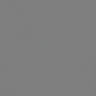
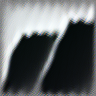
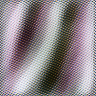
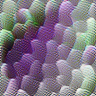
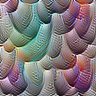
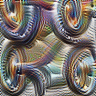
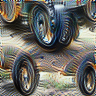
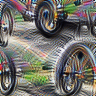
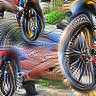
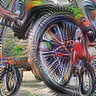
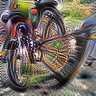
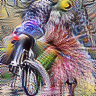


InceptionV2



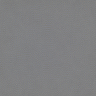
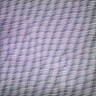
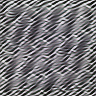
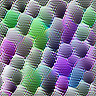
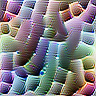
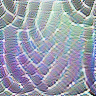
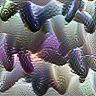
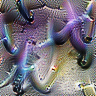
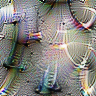
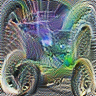
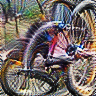
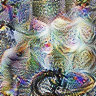
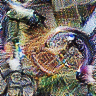


AlexNet



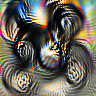
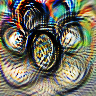

In [16]:
[mixed4d] = [layer for layer in InceptionV1_layers if layer.name == 'mixed4d']
layer, neuron = mixed4d, 484

print "InceptionV1"
vis_layer_analogies(layer, neuron, InceptionV1, InceptionV1_layers)

print ""
print "InceptionV2"
vis_layer_analogies(layer, neuron, InceptionV2, InceptionV2_layers)

print ""
print "AlexNet"
vis_layer_analogies(layer, neuron, AlexNet, AlexNet_layers)